##Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import itertools
import matplotlib.pyplot as plt
from google.colab import drive
from IPython.core.pylabtools import figsize
import tensorflow_probability as tfp
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout, Conv2DTranspose, Reshape,Layer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Tratamiento de datos

In [4]:
#obtener data de train y test
data_train = np.load("/content/drive/MyDrive/t2DL/data_train.pkl",allow_pickle=True, encoding="latin1")
real_test_label = np.load("/content/drive/MyDrive/t2DL/labels_test.pkl",allow_pickle=True, encoding="latin1")
test_data = np.load("/content/drive/MyDrive/t2DL/unlab_test.pkl", allow_pickle=True, encoding="latin1")

#Obtención de datos imágenes de train y test
##Sci images
x1_train = data_train['sci_images']
x1_train = x1_train.reshape(-1,21,21,1)
x1_test = test_data['sci_images']
x1_test = x1_test.reshape(-1,21,21,1)
##Temp images
x2_train = data_train['temp_images']
x2_train = x2_train.reshape(-1,21,21,1)
x2_test = test_data['temp_images']
x2_test = x2_test.reshape(-1,21,21,1)
##Diff Images
x3_train = data_train['diff_images']
x3_train = x3_train.reshape(-1,21,21,1)
x3_test = test_data['diff_images']
x3_test = x3_test.reshape(-1,21,21,1)
##SNR images
x4_train = data_train['SNR_images']
x4_train = x4_train.reshape(-1,21,21,1)
x4_test = test_data['SNR_images']
x4_test = x4_test.reshape(-1,21,21,1)

#Vector de training data de dimensiones (4026*4,21,21,1)
x_all_train = np.concatenate([x1_train,x2_train,x3_train,x4_train], axis=0)
#Vector de training data de dimensiones (4026,21,21,4)
x_all_train_four = np.concatenate([x1_train,x2_train,x3_train,x4_train], axis=3)

#Vector de test data de dimensiones(1000*4,21,21,1)
x_all_test = np.concatenate([x1_test,x2_test,x3_test,x4_test], axis=0)
#Vector de test data de dimensiones(1000,21,21,4)
x_all_test_four = np.concatenate([x1_test,x2_test,x3_test,x4_test], axis=3)

#Normalizar los datos de entrenamiento y test
x_all_train= x_all_train.astype('float32')/255.0
x_all_train_four= x_all_train.astype('float32')/255.0
x_all_test= x_all_test.astype('float32')/255.0
x_all_test_four= x_all_test.astype('float32')/255.0

#reshape a (21,21,4) (4 canales con cada uno es una imagen de 21x21)
x_all_train_four = x_all_train_four.reshape(-1,21,21,4)
x_all_test_four = x_all_test_four.reshape(-1,21,21,4)

#Obtención de las etiquetas de training de artefacto o real y encoding
y = data_train['labels'].reshape(-1,1)
ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y)
#Obtención de las etiquetas de testing de artefacto o real y encoding
y_real_test_labels = real_test_label['labels'].reshape(-1,1)
y_real = ohe.fit_transform(y_real_test_labels)

##Split de entrenamiento y validación para 4 canales
x_train, x_val, y_train, y_val = train_test_split(x_all_train_four, y, test_size=0.25)


#VAE

##Modelos

###VAE

####Sampling and Train function

In [2]:
#VAE sampling layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim)) #El epsilon es aleatorio 
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon #Se calcula z utilizando la formula z= mu + sigma*epsilon

#VAE training function
#Redefinición de función train_step, adecuada a la pérdida entre imágen real y imágen generada
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            print(f"Z, mean, var: {z}, {z_mean}, {z_log_var}")
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=0
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


####Encoder y Decoder

In [3]:
#Encoder
latent_dim = 2
encoder_inputs = Input(shape=(21, 21, 1))
encoder_vae_1 = Conv2D(filters=32, kernel_size=1, strides=(1, 1), activation='relu')(encoder_inputs) #Primera capa convolucional
encoder_vae_2 = Conv2D(filters=64, kernel_size=3, strides=(3, 3), activation='relu')(encoder_vae_1) #Segunda capa convolucional
encoder_vae_f = Flatten()(encoder_vae_2) 
#Capas que calculan la distribución
z_mean = Dense(latent_dim, name ="z_mean")(encoder_vae_f)
z_log_var = Dense(latent_dim, bias_initializer=initializers.Zeros(), name ="z_log_var")(encoder_vae_f)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
print(encoder.summary())

#Decoder
decoder_input = Input(shape=(latent_dim,))
decoder_vae_1 = Dense(units=3136, activation='relu')(decoder_input)
decoder_vae_2 = Reshape(target_shape=(7,7,64))(decoder_vae_1)
decoder_vae_3 = Conv2DTranspose(filters=32, kernel_size=3, strides=(3, 3),  padding='same', activation='relu')(decoder_vae_2)
decoder_out = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation="sigmoid")(decoder_vae_3)

decoder = Model(decoder_input, decoder_out, name ="decoder")
print(decoder.summary())

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 21, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 21, 21, 32)   64          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

####VAE Training

In [12]:
#Training VAE
history= vae.fit(x = x_all_train ,epochs=10, batch_size=32 ,verbose=True)

Epoch 1/10
Z, mean, var: Tensor("encoder/sampling/add:0", shape=(None, 2), dtype=float32), Tensor("encoder/z_mean/BiasAdd:0", shape=(None, 2), dtype=float32), Tensor("encoder/z_log_var/BiasAdd:0", shape=(None, 2), dtype=float32)
Z, mean, var: Tensor("encoder/sampling/add:0", shape=(None, 2), dtype=float32), Tensor("encoder/z_mean/BiasAdd:0", shape=(None, 2), dtype=float32), Tensor("encoder/z_log_var/BiasAdd:0", shape=(None, 2), dtype=float32)
504/504 [==============================] - 14s 25ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 2/10
504/504 [==============================] - 13s 25ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 3/10
504/504 [==============================] - 12s 24ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 4/10
504/504 [==============================] - 12s 24ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 5/10
504/504 [==============================] - 12s 24ms/step - loss: 

###Imágenes generadas

Imágenes generadas
[nan nan nan ... nan nan nan]


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


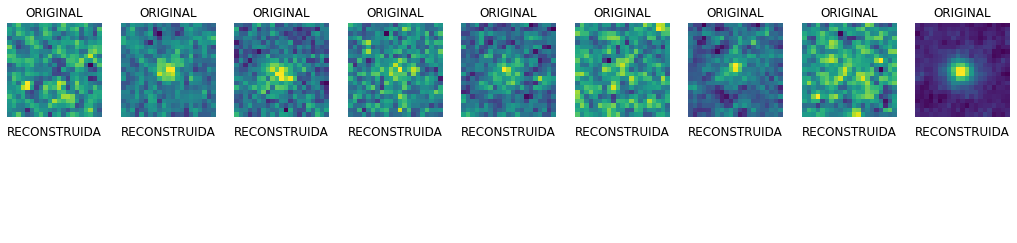

In [16]:
#Predicciones (generación de imágenes de testing)
z_mean_, z_log_var_, z_ = vae.encoder.predict(x_all_test)
generadas_ = vae.decoder.predict(z_)

plt.figure(figsize=(20, 4))

#Imprime las imágenes generadas por el VAE para verificar que no hayan valores vacíos
print("Imágenes generadas")
print(generadas_.flatten())
#Grafica las imágenes originales y las generadas por el VAE
for i in range(1,10):
    # Imagen Original
    ax = plt.subplot(2, 10, i)
    plt.title('ORIGINAL')
    plt.imshow(x_all_test[i,:,:,0])
    ax.axis('off')

    # Imagen Reconstruida
    ax = plt.subplot(2, 10, i + 10)
    plt.title('RECONSTRUIDA')
    plt.imshow(generadas_[i,:,:,0])
    ax.axis('off')

plt.show()

###Modelo clasificador Tarea 1

In [ ]:
#Modelo CNN de 3 capas convolucionales con 32 filtros de 2x2,3 max pooling de 2x2
#3 Dropouts de 25% y 2 capas densas (una con Dropout de 25%)
modeloco = Sequential()
modeloco.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(21,21,4)))
modeloco.add(MaxPooling2D(pool_size=(2,2)))
modeloco.add(Dropout(0.25))
modeloco.add(Conv2D(filters=32, kernel_size=(2,2)))
modeloco.add(MaxPooling2D(pool_size=(2,2)))
modeloco.add(Dropout(0.25))
modeloco.add(Conv2D(filters=32, kernel_size=(2,2)))
modeloco.add(MaxPooling2D(pool_size=(2,2)))
modeloco.add(Dropout(0.25))
modeloco.add(Flatten())
modeloco.add(Dense(units=32,activation='relu'))
modeloco.add(Dropout(0.25))
modeloco.add(Dense(units=2,activation='softmax'))
#modeloco.summary()
modeloco.compile(optimizer="adam", loss="mse", metrics = ["accuracy"])
modeloco_history = modeloco.fit(x = x_train, y = y_train, batch_size = 45, epochs = 100, validation_data = (x_val, y_val), verbose=False, callbacks=[EarlyStopping( monitor='loss', patience=5)])


##Resultados

###Confusion Matrix

In [ ]:
#función para imprimir la matríz de confusión
def plot_confusion_matrix(cm,classes,normalize=False,title="Confusion_matrix",cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm=cm.astype("float") / cm.sum(axis=1)[:,np.newaxis]
    cm = cm.round(decimals=4)

  thresh = cm.max() /2.
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
                    horizontalalignment="center",
                    color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.savefig("matrix.png")


###Scores train vs val

In [ ]:
##predicción de validación
y_test = modeloco.predict(x_val)
y_test = np.argmax(y_test,axis=1)
y_pred = y_val
y_pred = np.argmax(y_pred,axis=1)
#score entre predicciones y datos de validación
print("accuracy: ", accuracy_score (y_test, y_pred))
print("precision: ", precision_score (y_test, y_pred, average = 'macro'))
print("f1: ", f1_score (y_test, y_pred, average = 'macro'))


(1007, 2)
accuracy:  0.5024826216484608
precision:  0.5076849638238613
f1:  0.36087629042290525


###Predicciones

In [ ]:
#predicción de datos de test
y_test = modeloco.predict(x_all_test_four)
y_test = np.argmax(y_test,axis=1)
y_r = y_real
y_r = np.argmax(y_r,axis=1)
#save predictions
predictions = {'ID': test_data['ID'], 'predicted':y_test}
df_out = pd.DataFrame(predictions)
df_out.to_csv ("/content/drive/MyDrive/t2DL/modeloco_predictions.csv",index=False)
df_out.head()
#score entre predicciones y labels reales
print("accuracy: ", accuracy_score (y_test, y_r))
print("precision: ", precision_score (y_test, y_r, average = 'macro'))
print("f1: ", f1_score (y_test, y_r, average = 'macro'))


#score obtenido por modeloco_predictions.csv
#accuracy:  0.975
#precision:  0.9756107819691635
#recall:  0.9749315989055825
#f1:  0.9749889701358299

accuracy:  0.518
precision:  0.49979770789019345
f1:  0.3590391438252331


###Gráficos

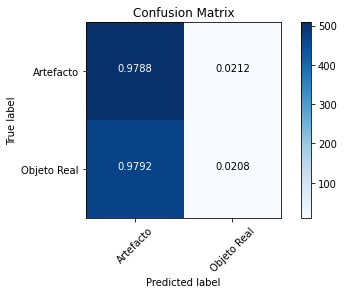

<Figure size 576x216 with 0 Axes>

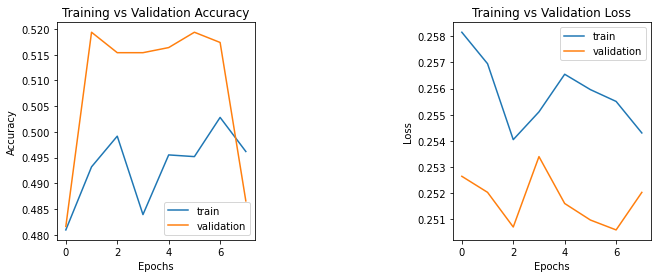

In [ ]:
#confusion matrix
cm_plot_labels = ["Artefacto","Objeto Real"]
cm = confusion_matrix(y_true=y_r,y_pred=y_test)
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,normalize=True, title="Confusion Matrix")

##Gráfico de accuracy y loss para datos de validación y train
plt.figure(figsize=(8,3))
fig, axs =plt.subplots(1,2)
plt.subplots_adjust(wspace=1, right=1.5)
#accuracy plot
axs[0].plot(modeloco_history.history['accuracy'])
axs[0].plot(modeloco_history.history['val_accuracy'])
axs[0].set(xlabel='Epochs', ylabel='Accuracy')
axs[0].set_title('Training vs Validation Accuracy')
axs[0].legend(['train', 'validation'])
#loss plot 
axs[1].plot(modeloco_history.history['loss'])
axs[1].plot(modeloco_history.history['val_loss'])
axs[1].set(xlabel='Epochs', ylabel='Loss')
axs[1].set_title('Training vs Validation Loss')
axs[1].legend(['train', 'validation'])

#Red bayesiana

##BNN

In [7]:
#Función que crea una red neuronal bayesiana para imágenes de 21*21*4
def red_bayesiana():
  kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(2, dtype=tf.float32))
  bnn_model = Sequential()
  bnn_model.add(Flatten(input_shape=(21,21,4)))
  bnn_model.add(tfp.python.layers.DenseFlipout(64, kernel_divergence_fn=kl_divergence_function, activation='relu'))
  bnn_model.add(tfp.python.layers.DenseFlipout(32, kernel_divergence_fn=kl_divergence_function, activation='relu'))
  bnn_model.add(tfp.python.layers.DenseFlipout(2, kernel_divergence_fn=kl_divergence_function, activation='softmax'))
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-04)
  bnn_model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
  return bnn_model

###Training

In [8]:
#Entrenamiento de la red bayesiana
model = red_bayesiana()
history = model.fit(x = x_train, y = y_train, validation_data = (x_val,y_val), epochs = 25, batch_size = 64)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


48/48 [==============================] - 3s 30ms/step - loss: 145394.6406 - accuracy: 0.5041 - val_loss: 145244.4531 - val_accuracy: 0.4846
Epoch 2/25
48/48 [==============================] - 1s 20ms/step - loss: 145105.6875 - accuracy: 0.4916 - val_loss: 144956.4062 - val_accuracy: 0.4737
Epoch 3/25
48/48 [==============================] - 1s 19ms/step - loss: 144818.5156 - accuracy: 0.5084 - val_loss: 144670.0000 - val_accuracy: 0.4677
Epoch 4/25
48/48 [==============================] - 1s 20ms/step - loss: 144532.8281 - accuracy: 0.5088 - val_loss: 144385.0938 - val_accuracy: 0.4955
Epoch 5/25
48/48 [==============================] - 1s 21ms/step - loss: 144248.5000 - accuracy: 0.5048 - val_loss: 144101.4219 - val_accuracy: 0.4856
Epoch 6/25
48/48 [==============================] - 1s 18ms/step - loss: 143965.3750 - accuracy: 0.5141 - val_loss: 143818.9375 - val_accuracy: 0.4836
Epoch 7/25
48/48 [==============================] - 1s 18ms/step - loss: 143683.4062 - accuracy: 0.5071 -

###Gráficos Accuracy y Loss en Training

<Figure size 576x216 with 0 Axes>

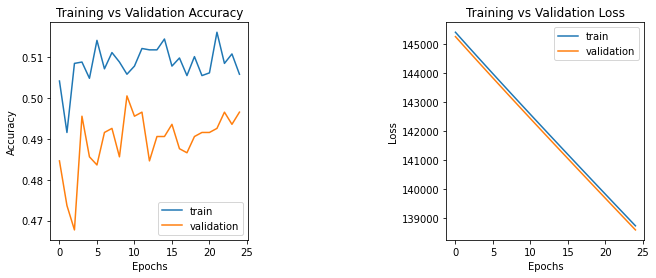

In [9]:
##Gráfico de accuracy y loss para datos de validación y train
plt.figure(figsize=(8,3))
fig, axs =plt.subplots(1,2)
plt.subplots_adjust(wspace=1, right=1.5)
#accuracy plot
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set(xlabel='Epochs', ylabel='Accuracy')
axs[0].set_title('Training vs Validation Accuracy')
axs[0].legend(['train', 'validation'])
#loss plot 
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set(xlabel='Epochs', ylabel='Loss')
axs[1].set_title('Training vs Validation Loss')
axs[1].legend(['train', 'validation'])

###Predictions

Etiqueta:  1
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  1.0
Std:  0.0


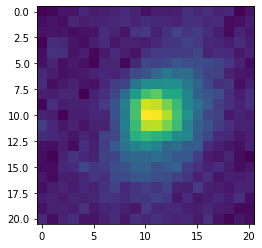

Etiqueta:  0
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  1.0
Std:  0.0


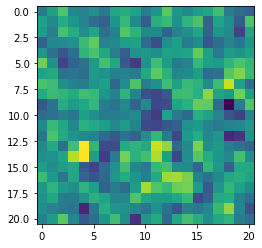

Etiqueta:  1
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  1.0
Std:  0.0


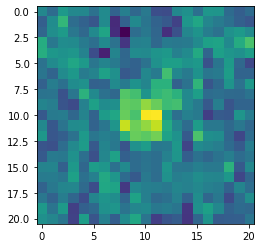

Etiqueta:  1
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Media:  0.98
Std:  0.13999999999999999


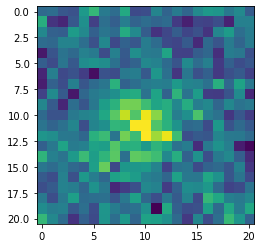

Etiqueta:  1
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  1.0
Std:  0.0


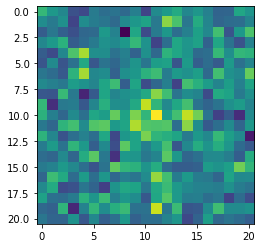

Etiqueta:  1
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  1.0
Std:  0.0


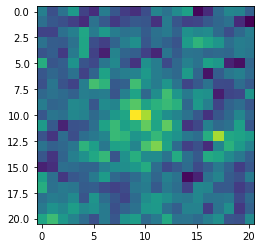

Etiqueta:  0
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  0.98
Std:  0.13999999999999999


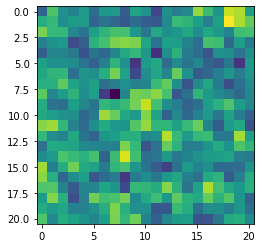

Etiqueta:  1
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  0.99
Std:  0.09949874371066199


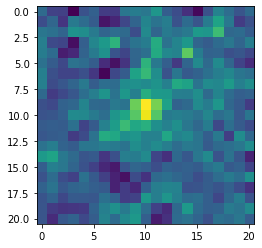

Etiqueta:  0
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  1.0
Std:  0.0


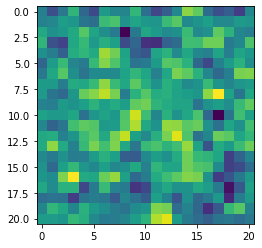

Etiqueta:  1
Prediccion:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Media:  1.0
Std:  0.0


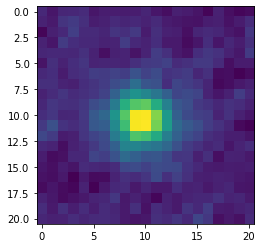

In [11]:
#Se predice 100 veces para 10 imágenes
num_samples = 100
imagenes = 10
predictions = []
for i in range(num_samples):
    #se le pasa una imagen de 21*21*4 a la red bayesiana
    aux = model.predict(x_all_test_four[:imagenes,:,:,:])
    #Se almacena la predicción
    predict = np.array([np.argmax(p) for p in aux]).reshape(-1,1)
    predictions.append(predict)
#Se guardan las predicciones por imagen
predictions = np.concatenate(predictions, axis=1)
#Se calcula la media y la desviación estándar de cada imagen
predictions_mean = np.mean(predictions, axis=1).tolist()
predictions_std = np.std(predictions, axis=1).tolist()

#Gráfica de las imágenes muestreadas
for i in range(imagenes):
    plt.imshow(x_all_test[i, :, :, 0])
    print("Etiqueta: ", np.argmax(y_real[i]))
    print("Prediccion: ", predictions[i])
    print("Media: ", predictions_mean[i] )
    print("Std: ", predictions_std[i] )
    plt.show()